# Introduction

Certaines choses étaient auparavant impossibles, et ce n’était peut-être pas si mal : une peinture rupestre représentant un dragon, un papyrus égyptien sensibilisant au réchauffement climatique, une stèle maya honorant Jair Bolsonaro, un paysage de Van Gogh représentant un parc éolien ou encore le portrait de Shrek version Andy Warhol. Les réseaux de neurones offrent aujourd’hui de nombreuses possibilités, comme celles de réaliser de tels anachronismes. Cela est possible grâce à la fusion esthétique de divers contenus visuels avec d’autres styles artistiques. 

Cette méthode de traitement d'image, appelée **transfert de style**, consiste à métamorphoser l'apparence d'une image en préservant son contenu visuel pour adopter le style artistique d'une autre image de référence.  

<img src="resources/images/introduction.png" alt="Texte alternatif de l'image" width="600"/>

Le transfert de style trouve des utilités dans des domaines divers grâce à sa capacité à créer des œuvres d'art uniques. Ces créations peuvent être largement exploitées dans les domaines de l'édition d'images et de la publicité. De plus, le transfert de style s'étend aujourd’hui au-delà de l'image statique, ce qui ouvre la porte à tous les domaines l’audiovisuel (ex. Cinéma) et même ceux de la réalité virtuelle et de la réalité augmentée. 

Divers procédés ont été mis en place pour réaliser ce transfert de style, chacun offre un apport dans le domaine malgré les différentes contraintes qu’il présente. L’article étudié est intitulé [*“Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization”* par Xun Huang et Serge Belongie](https://arxiv.org/abs/1703.06868). Publié en 2017 par le Département de Computer Science de Cornell University, il propose une méthode de transfert de style arbitraire en temps réel novatrice. Le terme “arbitraire” signifie que le choix du style pris en entrée n’est pas restreint à un ensemble prédéfini de styles spécifiques. Cette caractéristique permet aux utilisateurs de choisir librement le style qu'ils souhaitent appliquer à leur image et élargit ainsi la portée des applications de l'algorithme en offrant une plus grande liberté créative. 

La méthode appliquée dans l’article étudiée est basée sur une couche de normalisation d'instance adaptative (**AdaIN**) qui aligne la moyenne et la variance des caractéristiques du contenu avec celles du style. Cette approche atteint une vitesse comparable aux méthodes les plus rapides existantes, tout en éliminant la restriction à un ensemble prédéfini de styles. 

Ce Notebook vise à présenter le fonctionnement de l’algorithme de transfert de style arbitraire en temps réel ainsi que ses limitations. Nous allons tout d'abord nous intéresser aux algorithmes de transfert de style utilisés précédemment puis nous reviendrons sur les notions fondamentales. Nous nous pencherons ensuite sur l'architecture du modèle pour ensuite le ré-entrainer. Enfin, nous regarderons les limitations de ce modèle.

# État de l'art

Les réseaux neuronaux profonds (DNN) encodent à la fois le contenu et le style de l'image. Il est donc possible d’identifier et de séparer les informations relatives au style et au contenu pour créer de nouvelles images.  

[(Gatys et al., 2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) introduit un algorithme neuronal utilisant des réseaux de neurones convolutionnels (CNN). L’activation de certaines couches de neurones permet de capturer le contenu de l’image. Le style, quant-à-lui, est déduit des corrélations statistiques lors de l’activation des couches. Pour réaliser le transfert de style, [(Gatys et al., 2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) minimise la différence de contenu par rapport à l’image originale tout en recréant les statistiques du style souhaité. La méthode parvient à transférer le style souhaité sur le contenu initial, cependant, elle utilise un processus d'optimisation itératif lent et nécessite des images similaires en entrée. 

Plusieurs articles se consacrent à accélérer le processus de transfert. [(J.Johnson, 2016)](https://arxiv.org/abs/1603.08155) notamment entraîne un réseau neuronal convolutionnel feedforward. L’approche adoptée est basée sur le fait que la perception visuelle humaine est davantage axée sur des caractéristiques sémantiques et structurelles que sur des détails pixel à pixel. Ainsi, plutôt que de s’intéresser aux différences pixel à pixel, la méthode utilise les pertes perceptuelles pour mesurer la différence perceptuelle entre les images générées et les images de référence. Ces pertes perceptuelles sont obtenues grâce à des réseaux de neurones pré-entrainés, tels que VGG-19. Le processus d'optimisation permet d’obtenir des résultats en temps réel mais chaque réseau reste limité à un unique style.  

Les méthodes affranchies cette limitation sont soit restreintes à un ensemble fini de styles ou soit beaucoup plus lentes que les méthodes de transfert à style unique. Par exemple, [(Y. Li, 2017)](https://arxiv.org/abs/1705.08086) se concentre sur la reproduction des textures plutôt que de motifs spécifiques. L’utilisation de réseaux de neurones feedforward produit une image de sortie en temps réel mais la méthode reste restreinte à un ensemble fini de textures. 

L’article détaillé dans ce Notebook présente un algorithme de transfert de style neuronal en temps réel et dont le nombre de styles possible est arbitraire. La méthode développée combine la flexibilité sur le nombre de styles de [(Gatys et al., 2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)tout en offrant une vitesse de calcul similaire à celle de [(J.Johnson, 2016)](https://arxiv.org/abs/1603.08155)  grâce à l’utilisation de la normalisation d'instance adaptative, aussi appelé AdaIN. 

# Notions fondamentales

Dans le contexte des réseaux de neurones traitant des données bidimensionnelles (2D), comme les images, les données d'entrée sont habituellement représentées sous la forme d'un tenseur à quatre dimensions. Ce tenseur est noté $(N_{\text{total}}, C, H, W)$, où $N_{\text{total}}$ représente le nombre total d'images, $C$ le nombre de canaux (par exemple, 3 pour une image RGB), et $H$ et $W$ désignent respectivement la hauteur et la largeur de chaque image.

Un échantillon unique dans ce contexte correspond à une donnée 2D, c’est-à-dire une image, qui a pour dimension $(C, H, W)$.

Pour améliorer l'efficacité et la performance des réseaux de neurones, il est courant de regrouper les données en 'batches'. Un batch est un sous-ensemble du jeu de données complet et est de dimension $(N, C, H, W)$, où $N$ indique la taille du batch, c’est-à-dire le nombre d'échantillons traités ensemble lors d'une seule étape de l'apprentissage.

Nous utiliserons ces notations et concepts tout au long de notre explication.

In [2]:
## Librairies

import argparse
import sys
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
from torchvision.utils import save_image
from display import display_results

## Définition et calcul

### Normalisation

La normalisation des données joue un rôle crucial dans l'apprentissage des réseaux de neurones profonds. Bien que la normalisation à l'entrée soit essentielle, elle s'avère souvent insuffisante en raison d'un phénomène connu sous le nom de *'gradient evanescent'*. Ce dernier se manifeste par une réduction progressive de l'amplitude du gradient lors de la rétropropagation, particulièrement due aux faibles valeurs de sortie des couches d'activation, comme les fonctions sigmoid ou tanh. Dans les réseaux comportant de nombreuses couches, la multiplication répétée de ces petits termes peut entraîner la diminution significative du gradient.

Pour contrer ce problème, une renormalisation des données à travers les différentes couches du réseau s'avère nécessaire. De plus, un autre défi, connu sous le nom de *'décalage covariant interne'*, survient. Ce phénomène résulte de la modification de la distribution des activations à chaque couche, due aux transformations non linéaires appliquées par le réseau. Autrement dit, même si les données en entrée présentent une moyenne de 0 et une variance de 1, ces caractéristiques se déforment au fur et à mesure qu'elles traversent les différentes couches du réseau. Des techniques telles que Batch Normalisation ont été développées pour répondre à ces enjeux.

Bien que les objectifs de Batch Normalisation et de Instance Normalisation, telle que proposée dans le papier en question, soient différents (la première visant à renormaliser les données pour éviter les problèmes précédemment décrits, tandis que la seconde a pour but de neutraliser le contrast et la variation des couleurs au sein d'une image), une étude de Batch Normalisation reste pertinente. En effet, dans les deux cas, il s'agit d'une forme de normalisation des données, bien que leurs applications et finalités soient distinctes.

La formule générale pour la normalisation dans les réseaux de neurones est la suivante :

$$ Normalisation(x)=\gamma \left(\frac{x-\mu(x)}{\sigma(x)}\right)+\beta, $$

où $x$ est une image, $\gamma, \beta$ sont des paramètres affines extraits des données (les paramètres d'échelle et de décalage resp.). 

La différence dans les formules entre Instance Normalisation et Batch Normalisation vient dans la définition de $\mu(x), \sigma(x)$. 

### Batch Normalisation (BN)

Batch Normalisation consiste à normaliser les activations d'un réseau de neurones pour chaque lot (ou batch) de données traitées. Concrètement, au lieu de normaliser une seule image (ou échantillon), cette technique ajuste les activations de toutes les images dans un batch en fonction de la moyenne et de la variance calculées sur l'ensemble du batch, et ce, pour chaque canal de manière indépendante, comme illustré sur la figure ci-dessous. Ainsi, pour chaque canal, les activations sont d'abord centrées autour de zéro (en soustrayant la moyenne du batch) puis mises à l'échelle (en divisant par l'écart-type du batch).

Les expressios de la moyenne et de l'écart-type de BN sont les suivantes : 

$$\mu_{batch}(x) = \frac{1}{NHW}\sum_{n=1}^{N}\sum_{h=1}^{H}\sum_{w=1}^{W}x_{nchw},$$

$$
\sigma_{batch}(x) = \sqrt{\frac{1}{NHW} \sum_{n=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} \left(x_{nchw} - \mu_{batch}(x)\right)^2+\epsilon}, 
$$

où $x_{nchw}$ est une image de batch $n$ de taille $h$ x $w$ et de canal $c$. 


<img src="resources/images/BN.png" alt="CIN" width="300"/>

### Instance Normalisation (IN)

L'Instance Normalisation, ou normalisation d'instance, consiste à normaliser chaque échantillon individuellement en fonction de sa propre moyenne et variance pour chaque canal. Concrètement, cela signifie que pour chaque image dans un batch, la normalisation est effectuée séparément, canal par canal. Cette approche est particulièrement utile dans les tâches où l'indépendance entre les échantillons est cruciale, comme dans le transfert de style.

Les expressios de la moyenne et de l'écart-type de IN sont les suivantes : 

$$\mu_{image}(x) = \frac{1}{HW}\sum_{h=1}^{H}\sum_{w=1}^{W}x_{chw},$$

$$
\sigma_{image}(x) = \sqrt{\frac{1}{HW} \sum_{h=1}^{H} \sum_{w=1}^{W} \left(x_{chw} - \mu_{image}(x)\right)^2+\epsilon}, 
$$

où $x_{chw}$ est une image de taille $h$ x $w$ et de canal $c$. 


<img src="resources/images/IN.png" alt="CIN" width="300"/>

### Conditional Instance Normalisation (CIN)

La Conditional Instance Normalisation (CIN) est une extension de la méthode d'Instance Normalisation (IN) présentée dans l'article. La CIN introduit une condition supplémentaire qui permet d'ajuster la normalisation en fonction d'une information conditionnelle.

On a donc :

$$
CIN(x;s) = z(x;s) = \gamma_s \left(\frac{x-\mu(x)}{\sigma(x)}\right) + \beta_s
$$

Avec :

* $x$ : Représente les activations d’une couche de réseau de neurones
* $CIN(x;s)$ : Représente les activations normalisées
* $\mu$ et $\sigma$ : Moyenne et l'écart-type des activations de la couche x. Ces valeurs sont utilisées pour normaliser les activations et les rendre centrées et mises à l'échelle
* $\gamma$ et $\beta$ : Paramètres de normalisation affine. Ils sont sous forme de matrice NxC avec N le nombre de styles et C le nombre de feature maps

En d'autres termes, le processus de normalisation conditionnelle (CIN) consiste à ajuster les activations $x$ en fonction du style $s$ en utilisant des **paramètres spécifiques à ce style**.

La moyenne et l'écart-type sont calculés à partir des activations $x$, et ces valeurs sont utilisées pour **normaliser les activations**. Ensuite, les paramètres $\gamma_s$ et $\beta_s$, spécifiques au **style**, sont appliqués pour ajuster davantage les activations normalisées en fonction du style artistique souhaité.

<img src="resources/images/CIN.png" alt="CIN" width="600"/>

L'aspect **conditionnel** de la CIN réside dans le fait que les paramètres $\gamma$ et $\beta$ sont **conditionnés par le style de peinture spécifique $s$**. Cela signifie que, pour chaque style $s$, le modèle utilise des **paramètres de normalisation différents**, il peut maintenant non seulement apprendre à adapter le style en fonction de l'image source, mais aussi à ajuster ce style en fonction de conditions spécifiques en ajoutant cette condition et devient capable de faire du transfert de style tout en tenant compte d'une caractéristique spécifique définie.

Pendant l'entraînement, une image de style est choisie aléatoirement parmi un ensemble fixe de styles ($s \in \{ 1,2,…,S \}$). Le réseau d'apprentissage de style utilise ensuite les paramètres $\gamma_s$ et $\beta_s$ correspondants dans les couches CIN.
Le réseau peut générer des images dans des styles complètement différents en utilisant les mêmes paramètres de convolution mais des paramètres affines ($\gamma$ et $\beta$) différents dans les couches IN.

Une des limitations de cette méthode est qu'elle ajoute des paramètres proportionnels au nombre de styles, rendant difficile l'extension à un grand nombre de styles sans une augmentation linéaire des paramètres. De plus, cette approche ne peut pas s'adapter à de nouveaux styles sans ré-entraînement, limitant sa flexibilité.

En résumé, bien que la CIN permette d'ajuster le style en fonction de différents ensembles de paramètres, elle présente des limitations en termes de complexité et de flexibilité pour gérer un grand nombre de styles.

## Interprétation Instance Normalisation

Malgré le succès de l'IN, les raisons précises pour lesquelles elle fonctionne particulièrement bien pour le transfert de style ne sont pas complètement comprises. Une hypothèse suggère que l'IN est invariant au contraste de l'image source, mais cette explication semble limitée. L'IN agit dans l'espace des caractéristiques plutôt que dans l'espace des pixels, ce qui suggère que son impact va au-delà d'une simple normalisation du contraste.

Les auteurs soutiennent que la normalisation d'instance effectue une forme de normalisation de style en normalisant les statistiques des caractéristiques, notamment la moyenne et la variance. En effet, les statistiques des caractéristiques d’un DNN sont capables de capturer le style d’une image. Les auteurs pensent que les statistiques des caractéristiques d'un réseau générateur peuvent également contrôler le style de l'image générée.

Les chercheurs ont observé que les paramètres affines (les paramètres qui agissent sur l'étirement et la translation) dans l'IN peuvent altérer complètement le style de l'image de sortie. L'IN semble effectuer une sorte de normalisation de style en agissant sur ces statistiques, en particulier la moyenne et la variance des caractéristiques.

Les auteurs ont ensuite décidé de comparer cette méthode avec la **Batch Normalisation** :

* Lors du transfert de style, le modèle avec l'IN converge plus rapidement que celui avec BN

* Même après la normalisation du contraste des images d'entraînement, l'IN reste efficace

* Lorsque les images d'entraînement sont normalisées vers un style spécifique, l'amélioration apportée par IN diminue, indiquant que la normalisation du style n'est pas parfaite

* Les modèles avec BN, entraînés sur des images avec normalisation de style, peuvent converger aussi rapidement que les modèles avec IN entraînés sur des images originales. Cela suggère que l'IN effectue une forme de normalisation de style, tandis que la BN, bien qu'elle normalise les statistiques des caractéristiques d'un lot, ne garantit pas un transfert global vers un style unique, ce qui est essentiel dans le transfert de style à propagation avant

L'IN peut normaliser le style de chaque échantillon individuel vers le style cible, ce qui facilite l'entraînement. Les autres parties du réseau peuvent alors se concentrer le contenu tout en éliminant l'information de style originale. Cela explique le succès de l'IN dans le transfert de style. De plus, l'explication devient claire pour la Conditional Instance Normalisation (CIN) : des paramètres affines différents peuvent normaliser les statistiques des caractéristiques vers des valeurs différentes, entraînant ainsi une normalisation de l'image de sortie vers différents styles.

En résumé, l'IN semble jouer un rôle important dans la normalisation du style pendant le transfert de style, en agissant sur les caractéristiques plutôt que sur les pixels, et en permettant une normalisation fine et spécifique au style pour chaque échantillon individuel.

## Différences dans l'application

La normalisation par batchs suppose que les images dans un batch donné sont représentatives de l'ensemble du jeu de données. Cette hypothèse peut ne pas toujours être vraie, surtout pour les petits batchs.

D'autre part, la normalisation d'instance (Instance Normalisation) opère sous l'hypothèse que chaque image possède son propre style. En conséquence, elle normalise les données en fonction de la moyenne et de la variance de chaque échantillon individuel, et ce, pour chaque canal. Cette méthode est particulièrement adaptée à des applications telles que le transfert de style, où le style unique de chaque image est un facteur clé.

Pour la Batch Normalisation (BN), les couches utilisent des statistiques de batch (moyenne et variance) durant l'entraînement, et des statistiques de population (moyenne et variance de l'ensemble de données d'apprentissage) durant le test. Ceci est dû à l'hypothèse de BN selon laquelle un batch est représentatif de l'ensemble du jeu de données d'apprentissage, ce qui n'est pas nécessairement le cas dans un contexte de test. Pour améliorer la robustesse, on remplace donc les statistiques du batch par celles de la population durant l'inférence. En revanche, la normalisation d'instance (IN) ne repose pas sur une telle hypothèse. Ainsi, les statistiques restent inchangées entre l'apprentissage et le test. En résumé, pour la BN, les statistiques utilisées durant l'inférence sont fixes (celles tirées de l'ensemble d'entraînement), tandis que pour l'IN, les statistiques sont calculées aussi bien durant l'apprentissage que lors du test.

<img src="resources/images/BN_vs_IN.png" alt="CIN" width="600"/>

D'après les graphiques présentés ci-dessus, on observe que l'Instance Normalisation (IN) contribue significativement à la réduction de la perte de style lorsqu'on entraîne le réseau avec des images originales et celles normalisées en termes de contraste. Toutefois, l'amélioration apportée par l'IN semble moins marquée pour les images préalablement normalisées en fonction de leur style. Cette observation s'aligne avec les explications précédentes : l'un des principaux atouts de l'IN réside dans son adaptation aux cas où chaque image présente un style individuel distinct. Or, dans cette situation, le style intrinsèque des images d'entrée a été normalisé, ce qui réduit l'effet et l'utilité de l'IN. Par conséquent, les améliorations apportées par l'IN dans ce contexte spécifique apparaissent relativement limitées.

# Architecture

On considére deux images de même taille : une correspondant à l'image de contenu notée **ImgC** et une correspondant à l'image style notée **ImgS**.  Le transfert de style repose sur un mécanisme qui comprend un encodeur, AdaIN et un décodeur. 

## Encodeur 

![Texte alternatif de l'image](resources/images/imageencodeur.png)

L'encodeur va permettre d'extraire les **features** de l'image de contenue **ImgC**  d'une part et les **features** de l'image de style **ImgS** d'autre part, que l'on note respectivement **f(ImgC)** et **f(ImgS)**  Cette encodeur est composé de 13 couches de réseaux de neuronnes dont 10 couches de convolutions et 3 couche de Maxpoolings. Considérons une image d'entrée de dimension (h,w,c), alors on décrit l'encodeur par le tableau suivant : 

![Texte alternatif de l'image](resources/images/Encodeur.png)



où h, w et c sont respectivement la hauteur, la largeur et le nombre de canaux de l'image en entrée. De plus, les dimensions des cartes fonctionnelles intermédiaires sont données par les formules suivantes:

$w_1$=$[\frac{w}{2}-1]+1$ , $h_1$= $[\frac{h}{2}-1]+1$

$w_2$=$[\frac{w_1}{2}-1]+1$, $h_2$=$[\frac{h_1}{2}-1]+1$

$w_3$=$[\frac{w_2}{2}-1]+1$, $h_3$=$[\frac{h_2}{2}-1]+1$

**Remarque :**

L’encodeur transforme l’entrée en une représentation dans un espace de dimension plus faible appelé espace latent. L’encodeur compresse donc l’entrée dans une représentation moins coûteuse. 

## ADAIN 

Après l’encodeur, nous connaissons la taille de la carte de fonctionnalités : pour une image d’entrée (w,h,c), nous obtenons une carte de fonctionnalités de dimension ($w_3$, $h_3$, 512) pour l'image de style et de contenu.  L'instance de normalisation adaptative opère en normalisant la carte de fonctionnalités de l'image de contenu, représentée par $x = \text{f(ImgC)}$, en se basant sur les statistiques obtenues à partir de la carte de fonctionnalités de l'image style, notée $y = \text{f(ImgS)}$. Nous avons illustrer le mécanisme par le schéma suivant :

![Texte alternatif de l'image](resources/images/ADAIN.jpg)


La première étape de ce processus implique le calcul de la moyenne des valeurs des pixels de chaque canal sur toute la largeur et la hauteur du tenseur d'entrée, ainsi que l'écart-type des valeurs des pixels de chaque canal sur l'ensemble de ces dimensions. En résultat, nous obtenons des vecteurs moyennes $\mu_c$ et $\mu_s$ pour chaque canal de la carte de fonctionnalités de contenu et de style, accompagnés de leurs écart-types respectifs notés  $\sigma_c$ et $\sigma_s$, tous ces vecteurs étant de dimension 512.

La seconde étape consiste à normaliser chacun des pixels de la carte de fonctionnalité de contenus par la moyenne $\mu_c^c$ et l'écart-type $\sigma_c^c$ de tout valeurs des pixels qui appartiennent au même canal. Cette valeur va être alignée aux valeurs de la carte fonctionnalité de style en multipliant l'écart-type $\sigma_s^c$ de toutes les valeurs des pixels qui appartiennent au même canal dans la carte de fonctionnalité style et en y ajoutant la moyenne $\mu_s^c$.

A la fin de ces étapes, nous obtenons donc la carte de fonctionalité cible que l'on note $t=\text{AdaIN}(x,y)$.

![Texte alternatif de l'image](resources/images/adainschema.png)

In [6]:
class AdaIN(nn.Module): #module = couche ou pls couches d'un réseau 
	def __init__(self):
		super().__init__()

	def forward(self, x, y): #forward pass de la couche, x et y les entrées de la couche = eux-mêmes des tenseurs (ici sorties des 4 couches vgg), x et y issus de content et style images 
		eps = 1e-5	
		mean_x = torch.mean(x, dim=[2,3]) #calcule la moyenne du tenseur x le long des dim 2 et 3 (dim 2 et 3 = W et H donc on calcule la moyenne le long des valeurs spatiales de x), mean_x est un tenseur de dim 2 (N et C)
		mean_y = torch.mean(y, dim=[2,3]) #cela correspond bien a IN car on va normaliser par chaque sample de batch

		std_x = torch.std(x, dim=[2,3]) 
		std_y = torch.std(y, dim=[2,3])

		mean_x = mean_x.unsqueeze(-1).unsqueeze(-1) #on ajoute 2 dims suppl"mentaires à la fin pour obtenir un tenseur de dim 4 (devient (N,C)-> (N,C,1,1)), nécessaire car x de dim 4
		mean_y = mean_y.unsqueeze(-1).unsqueeze(-1) #unsqueeze similaire au view, les deux sont utilisés pour reshape les entrées

		std_x = std_x.unsqueeze(-1).unsqueeze(-1) + eps #on ajoute eps pour eviter de diviser par 0 
		std_y = std_y.unsqueeze(-1).unsqueeze(-1) + eps

		out = (x - mean_x)/ std_x * std_y + mean_y #on normalize d'abord x par sa moyennne et écart type et ensuite on fait l'inverse avec l'écart type et la moyenne de y pour obtenir out qui va avoir la moyenne et l'écart type de y


		return out #on obtient le tenseur out qui a le contenu de x mais les features de y 

In [7]:
class StyleTransferNet(nn.Module):
	def __init__(self, vgg_model):
		super().__init__()

		vggnet.load_state_dict(vgg_model) #on load les poids deja obtenus ds vgg_model dans vggnet

		self.encoder = nn.Sequential( #on code encoder, 1er élément de notre réseau
			nn.Conv2d(3, 3, kernel_size=(1,1), stride= (1, 1)),
			nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),

			nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

			nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),


			nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
			
			nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),


			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
			
			nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True)
			)

		self.encoder.load_state_dict(vggnet[:21].state_dict()) #on récupère les poids des premières 21 couches de vggnet (tout jusqu'a relu 4_1 exclu)
		for parameter in self.encoder.parameters():
			parameter.requires_grad = False
			
		self.decoder = nn.Sequential(
			nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),

			nn.Upsample(scale_factor=2, mode='nearest'), #upsample augmente les dim de tenseur par scale_factor, nearest mode = les nouvelles cases remplies par la valeur de pixel le + proche 
			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),

			nn.Upsample(scale_factor=2, mode='nearest'),
			nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),

			nn.Upsample(scale_factor=2, mode='nearest'), #upsample utilise au lieu de maxpool pour éviter checkerboard effects
			nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),

			)
		self.adaIN = AdaIN()
		self.mse_criterion = nn.MSELoss()


	def forward(self, x, alpha=1.0):

		content_img = x[0]
		style_img = x[1]

		encode_content = self.encoder(content_img) #f(c)
		encode_style = self.encoder(style_img) #f(s)

		encode_out = self.adaIN(encode_content, encode_style) #AdaIN(f(c),f(s))=t
		

		if self.training:
			gen_img = self.decoder(encode_out) #g(t)
			encode_gen = self.encoder(gen_img) #f(g(t)) -> on va l'utiliser pour la loss_c

			#on divise encoder par chaque couche pour appliquer la somme de L_s sur les sorties des couches de vgg, les fm sont des phi de la formule, prq cette division ? L=4 (3 ici et encode_gen/style étant déjà calculés)
			fm11_style = self.encoder[:3](style_img)
			fm11_gen = self.encoder[:3](gen_img)

			fm21_style = self.encoder[3:8](fm11_style)
			fm21_gen = self.encoder[3:8](fm11_gen)

			fm31_style = self.encoder[8:13](fm21_style)
			fm31_gen = self.encoder[8:13](fm21_gen)
			
			loss_content = self.mse_criterion(encode_gen, encode_out) #formule de l'article

			loss_style = self.mse_criterion(torch.mean(fm11_gen, dim=[2,3]), torch.mean(fm11_style, dim=[2,3])) +	\
						self.mse_criterion(torch.mean(fm21_gen, dim=[2,3]), torch.mean(fm21_style, dim=[2,3])) +	\
						self.mse_criterion(torch.mean(fm31_gen, dim=[2,3]), torch.mean(fm31_style, dim=[2,3])) +	\
						self.mse_criterion(torch.mean(encode_gen, dim=[2,3]), torch.mean(encode_style, dim=[2,3])) +	\
						self.mse_criterion(torch.std(fm11_gen, dim=[2,3]), torch.std(fm11_style, dim=[2,3])) +	\
						self.mse_criterion(torch.std(fm21_gen, dim=[2,3]), torch.std(fm21_style, dim=[2,3])) +	\
						self.mse_criterion(torch.std(fm31_gen, dim=[2,3]), torch.std(fm31_style, dim=[2,3])) +	\
						self.mse_criterion(torch.std(encode_gen, dim=[2,3]), torch.std(encode_style, dim=[2,3])) 

			return loss_content, loss_style
		encode_out = alpha * encode_out + (1-alpha)* encode_content 
		gen_img = self.decoder(encode_out) #=g(alpha*t+(1-alpha)*f(c))
		return gen_img

## Décodeur 

![Texte alternatif de l'image](resources/images/imagedécodeur.png)

A partir du **feature de cible**, c'est à dire les features obtenues par la méthode AdaIN, le décodeur va essayer de reconstruire l'image de contenu stylisée. Le décodeur est composé de 12 couches de réseaux de neurones dont 10 couches de convolutions et de Upsampling.  

![Texte alternatif de l'image](resources/images/decodeur.png)

**Remarque :** 

On remarque la présence de 3 couche Upsampling permettant de redimensionner ou agrandir le tenseur d'entrée d’un facteur 2, *‘nearest’* indique une interpolation par le plus proche voisin. Cette méthode attribue la valeur du pixel d'entrée le plus proche au pixel correspondant en sortie, en faisant une méthode d'interpolation simple et rapide.

**Nombre total de paramètres à estimer :**

$5 240 704 + 3 \times c$


In [8]:
vggnet = nn.Sequential(
			# encode 1-1
			nn.Conv2d(3, 3, kernel_size=(1,1), stride= (1, 1)), #1er 3 = nb de channels, 2e 3 = nb de filtres de cette couche
			nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'), #idem mais avec padding reflect = au lieu de remplir les bords avec 0, on les remplit avec des valeurs proches des bords pour eviter le edge effect
			nn.ReLU(inplace=True), # relu 1-1, ReLu = max (0,x)
			# encode 2-1
			nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True), #inplace = modif l'input directement sans allouer la memoire supp 
			nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), #no padding, no dilation (=ajouter des espaces entre les elements des filtres pour couvrir plus, pas trop trop compris), ceil_mode=False donc on arrondit par truncation 

			nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True), # relu 2-1
			# encoder 3-1
			nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),

			nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
			nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True), # relu 3-1
			# encoder 4-1
			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

			nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True), # relu 4-1
			
			nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

			nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True),
			nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
			nn.ReLU(inplace=True)
			)

## Perte liée au contenue

   Cette perte permet de quantifier la perte liées au contenue en effet l’encodeur va permettre d’extraire les features des images de style $f(ImgS)$ et de contenue $f(ImgC)$. Ces features vont être transmise à la couche $ADAIN()$ qui aligne la moyenne et la variance des cartes de fonctionnalités de contenu sur celles de les cartes de caractéristiques de style, produisant les caractéristiques cibles que l'on note t= $ADAIN(f(ImgS), f(ImgC))$. 

![Texte alternatif de l'image](resources/images/architecture.jpg)

 Ensuite cette carte de fonctionnalités va être reconstruite par un décodeur afin d’avoir une image ayant le contenue et style souhaité $g(t)$ . Ensuite, on va extraire la carte fonctionnelle de cette image dont le contenu à été stylisé, on passe par un encodeur : on obtient les caractéristique de l’image reconstruite ayant le contenue et style souhaité $f(g(t))$. 


$$ L_c = || f(g(t)) -t||_2$$

La perte du contenu correspond à la différence euclidienne entre les caractéristiques de fonctionnalité à la sortie de l’AdaIN et celle extraite de l’image reconstruite ayant le contenue et style souhaité, dont on vérifie bien la compatibilité au niveau des dimensions. 

## Perte liée au style

Le transfert de style s'effectue en adaptant les statistiques de l'image de contenu pour correspondre à celles de l'image de style, en se concentrant particulièrement sur la moyenne et l'écart-type. Ainsi, il est logique d'utiliser une perte de style qui vise à minimiser la différence entre ces statistiques pour la sortie du réseau et l'image de style de référence. La formule de perte de style présentée dans le papier est la suivante :

$$
L_s = \sum_{i=1}^{L} \left\| \mu(\phi_i(g(t))) - \mu(\phi_i(s)) \right\|^2 + \sum_{i=1}^{L} \left\| \sigma(\phi_i(g(t))) - \sigma(\phi_i(s)) \right\|^2,
$$
où $L$ est le nombre total des couches de VGG-19, $\mu$ et $\sigma$ sont respectivement la moyenne et l'écart-type des activations d'une couche de VGG-19, $s$ est l'image de style de référence et $g(t)$ est l'image stylisée, i.e. la sortie finale du réseau. 

**Remarque :** Dans leurs expériences, les auteurs ont choisi d'utiliser quatre couches spécifiques du réseau VGG-19.

Le papier mentionne également l'usage courant de la perte de Gram, une autre méthode fréquemment employée dans le transfert de style. Cependant, bien que les résultats obtenus avec cette méthode soient similaires, les auteurs soulignent qu'il est conceptuellement plus approprié d'adopter la perte de style décrite précédemment. Cette approche est en effet plus cohérente avec l'objectif de minimiser les différences entre les statistiques clés (moyenne et écart-type) des images de style et de contenu.

## Perte du modèle 

$$ L = \alpha || f(g(t)) -t||_2 + (1-\alpha) (\sum_{i=1}^{L} \left\| \mu(\phi_i(g(t))) - \mu(\phi_i(s)) \right\|^2 + \sum_{i=1}^{L} \left\| \sigma(\phi_i(g(t))) - \sigma(\phi_i(s)) \right\|^2)$$

**Remarque :** 
- Lorsque $\alpha$ tend vers 0, on accorde plus d'importance a la perte lié au style donc on accorde plus d'importance au style. 
- Lorsque $\alpha$ tend vers 1, on accorde plus d'importance au contenue de l'image de contenu. 

# Essais avec modèle pré-entrainé

Les auteurs ont fait le choix d'utiliser à entrainé le modèle AdaIN sur les images de contenu : [**MSCOCO**](https://cocodataset.org/#home) , qui contient plus de 330 000 images de contenu, ainsi que sur les images styles : [**WikiArt**](https://www.wikiart.org/fr), qui contient plus de 42 129 images styles de 193 artistes différents.

In [13]:
# Entrer les paths des images souhaitées
style_img = 'data/input_img/impressionisme1.jpg'
content_img = 'data/input_img/mohamedali.jpg'

# Donner une valeur entre 0.0 et 1.0 à alpha (Niveau de transfert de style)
alpha = 0.7

In [14]:
class AlphaRange(object):
	def __init__(self, start, end):
		self.start = start
		self.end = end
	def __eq__(self, other):
		return self.start <= other <= self.end
	def __str__(self):
		return 'Alpha Range'

sys.argv = ['ProjetHDDL', '--input_image', content_img, '--style_image', style_img, '--weight', 'decoder.pth','--alpha',str(alpha),'--cuda',]

# Définition des arguments requis lors de l'exécution du code
parser = argparse.ArgumentParser()
parser.add_argument('--input_image', type=str, help='test image')# Path de l'image d'entrée (de contenu)
parser.add_argument('--style_image', type=str, help='style image')# Path de l'image de style
parser.add_argument('--weight', type=str, help='decoder weight file')# Fichier contenant les données des poids
parser.add_argument('--alpha', type=float, default=1.0, choices=[AlphaRange(0.0, 1.0)], help='Level of style transfer, value between 0 and 1')
# Niveau de transfert de style
parser.add_argument('--cuda', action='store_true', help='Using GPU to train')# Uses GPU to train


if __name__ == '__main__':
    # Recupere et stocke les arguments donnés
    opt =parser.parse_args()
    input_image = Image.open(opt.input_image)
    style_image = Image.open(opt.style_image)
    size = np.shape(style_image)
    if (len(size) == 2) :
        style_image = style_image.convert('RGB')
            
    output_format = opt.input_image[opt.input_image.find('.'):]# Le format de l'image de sortie et le même que celui de l'image de contenu
    # Cree le repertoire de sortie
    out_dir = './data/out_img/'
    os.makedirs(out_dir, exist_ok=True)
    with torch.no_grad():
        vgg_model = torch.load('vgg_normalized.pth')# Load le modele
        
        net = StyleTransferNet(vgg_model)
        net.decoder.load_state_dict(torch.load(opt.weight))# Load les poids
        
        net.eval()
        # Reshape les deux images d'entree à la même taille
        input_image = transforms.Resize(512)(input_image)
        style_image = transforms.Resize(512)(style_image)
        # Transforme les images en tenseurs
        input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)
        style_tensor = transforms.ToTensor()(style_image).unsqueeze(0)
        
        
        if torch.cuda.is_available() and opt.cuda:
            net.cuda()
            input_tensor = input_tensor.cuda()
            style_tensor = style_tensor.cuda()
            
        out_tensor = net([input_tensor, style_tensor], alpha = opt.alpha)# Applique le modèle aux images choisies
        
        out_img = out_dir + opt.input_image[opt.input_image.rfind('/')+1: opt.input_image.find('.')]+ '_' + opt.style_image[opt.style_image.rfind('/')+1: opt.style_image.find('.')]+ output_format
        save_image(out_tensor, out_img)# Sauvegarde de l'image de sortie

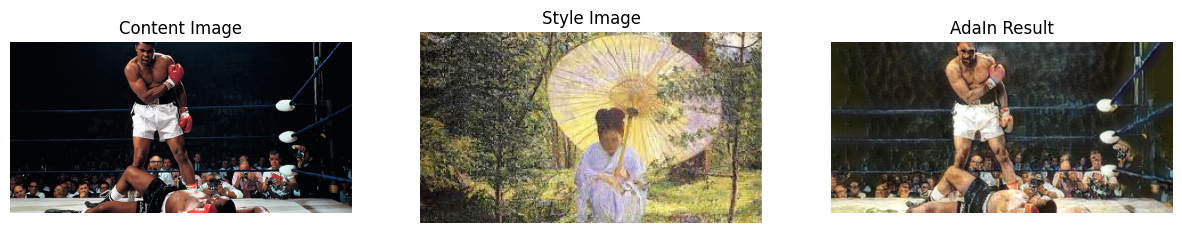

In [15]:
display_results(content_img,style_img,out_img) 

Nous avons testé sur différents types d'images, dont les résultats sont les suivants : 

![Texte alternatif de l'image](resources/images/taylorjoconde.png)

![Texte alternatif de l'image](resources/images/sofiadame.png)

![Texte alternatif de l'image](resources/images/monroepoint.png)

**Remarque :** 

Nous pouvons remarquer qu'avec le modèle pré-entrainé, le transfert de couleur et de forme est efficace. Cependant, le transfert de texture laisse à désirer, ceci peut être expliqué par la rapidité de la méthode AdaIN qui utilise l'inférence des features style et image. 

![Texte alternatif de l'image](resources/images/fridapoint.png)

**Remarque : a rephraser** 

L’utilisation de la perte de style des statistiques de second ordre dans le transfert de style : adapté pour capturer le contenu global mais pas les détails plus fins. 


# Entrainement 

Durant l'entrainement, nous avons cherche à estimer $5 240 704 + 3 \times c$ paramètres. Nous avons entrainé notre modèle sur une base de donnée avec un faible nombres d'images. Nous importons donc les paramétres du réseaux. Afin d'entrainer notre modèle, nous avons utilisé les données du [GitHub](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) de nos camarades qui ont travaillé sur la partie CycleGAN. 

## Algorithme de test

In [18]:
# Entrer les paths des images souhaitées
style_img = 'data/input_img/stylebaroque.jpg'
content_img = 'data/input_img/sofiacoppola.jpeg'

# Donner une valeur entre 0.0 et 1.0 à alpha (Niveau de transfert de style)
alpha = 0.7

In [19]:
class AlphaRange(object):
	def __init__(self, start, end):
		self.start = start
		self.end = end
	def __eq__(self, other):
		return self.start <= other <= self.end
	def __str__(self):
		return 'Alpha Range'

sys.argv = ['ProjetHDDL', '--input_image', content_img, '--style_image', style_img, '--weight', 'decoder_retrained.pth','--alpha',str(alpha),'--cuda',]

# Définition des arguments requis lors de l'exécution du code
parser = argparse.ArgumentParser()
parser.add_argument('--input_image', type=str, help='test image')# Path de l'image d'entree (de contenu)
parser.add_argument('--style_image', type=str, help='style image')# Path de l'image de style
parser.add_argument('--weight', type=str, help='decoder weight file')# Fichier contenant les données des poids
parser.add_argument('--alpha', type=float, default=1.0, choices=[AlphaRange(0.0, 1.0)], help='Level of style transfer, value between 0 and 1')
# Niveau de transfert de style
parser.add_argument('--cuda', action='store_true', help='Using GPU to train')# Uses GPU to train


if __name__ == '__main__':
    # Recupere et stocke les arguments donnés
    opt =parser.parse_args()
    input_image = Image.open(opt.input_image)
    style_image = Image.open(opt.style_image)
    size = np.shape(style_image)
    if (len(size) == 2) :
        style_image = style_image.convert('RGB')
            
    output_format = opt.input_image[opt.input_image.find('.'):]# Le format de l'image de sortie et le même que celui de l'image de contenu
    # Cree le repertoire de sortie
    out_dir = './data/out_img/'
    os.makedirs(out_dir, exist_ok=True)
    with torch.no_grad():
        vgg_model = torch.load('vgg_normalized.pth')# Load le modele
        
        net = StyleTransferNet(vgg_model)
        net.decoder.load_state_dict(torch.load(opt.weight,map_location=torch.device('cpu')))# Load les poids
        
        net.eval()
        # Reshape les deux images d'entree à la même taille
        input_image = transforms.Resize(512)(input_image)
        style_image = transforms.Resize(512)(style_image)
        # Transforme les images en tenseurs
        input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)
        style_tensor = transforms.ToTensor()(style_image).unsqueeze(0)
        
        
        if torch.cuda.is_available() and opt.cuda:
            net.cuda()
            input_tensor = input_tensor.cuda()
            style_tensor = style_tensor.cuda()
            
        out_tensor = net([input_tensor, style_tensor], alpha = opt.alpha)# Applique le modèle aux images choisies
        
        out_img = out_dir + opt.input_image[opt.input_image.rfind('/')+1: opt.input_image.find('.')]+ '_' + opt.style_image[opt.style_image.rfind('/')+1: opt.style_image.find('.')]+ output_format
        save_image(out_tensor, out_img)# Sauvegarde de l'image de sortie

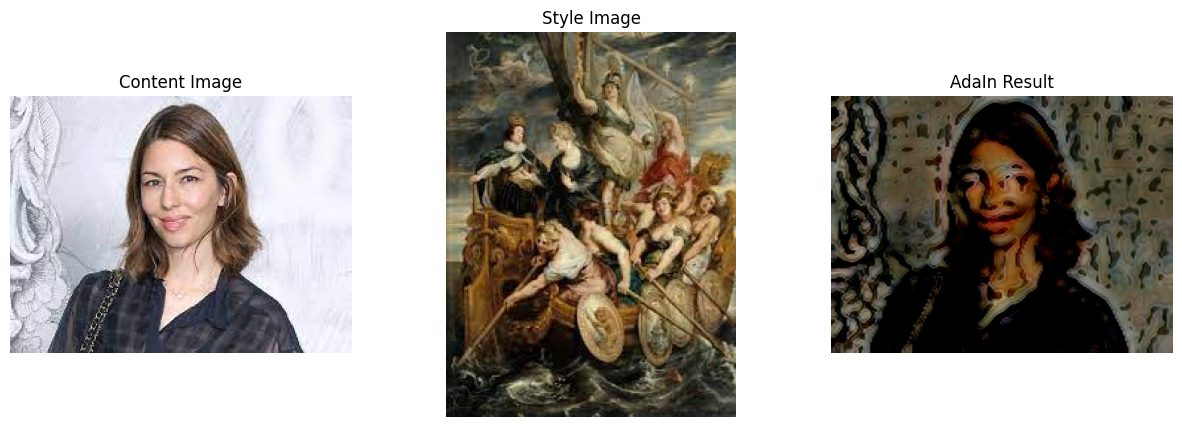

In [20]:
display_results(content_img,style_img,out_img) 

![Texte alternatif de l'image](resources/images/taylorentrainé.png)

Nous avons testé notre entrainement sur plusieurs types d'art.

### L'impressionisme : 

L'impressionisme est un mouvement artistique caractérisé par des scènes en pleine air, un traitement de lumière par des touches fragmentées (rapide en virgule) utilisant ainsi plus de couleurs primaires et leurs complémentaires. 

![Texte alternatif de l'image](resources/images/fridamodeleentraine.png) 

![Texte alternatif de l'image](resources/images/sofiaentraine.png) 

### Le Cubisme :  

Le cubisme est caractérisé par la géométrisation de l'objet peint, en cube. 

![Texte alternatif de l'image](resources/images/cubisme_entrainement.png) 

### Le pointillisme :


Le pointillisme consite en la juxtaposition de points de divers couleurs, sans mélanger la couleur. 

![Texte alternatif de l'image](resources/images/monroepoint_entrainement.png) 

### Le baroque :

Le baroque est caractérisé par la liberté des formes et la profusion des ornements.

![Texte alternatif de l'image](resources/images/baroque_entrainement.png) 

![Texte alternatif de l'image](resources/images/megan_entrainement.png) 

**Remarque :** 

Globalement, les couleurs de l'image de style et les formes de l'image de contenu sont très bien transmises à l'image de contenu stylisée. Nous remarquons que la texture est moins bien transmise à l'image finale, cela peut-être du à la faible variété de données artistiques dans le dataset que nous avons utilisé. 

## Amélioration possible :  

Nous avons commencé à entrainer le modéle AdaIN sur les images de contenu : [**PASCAL VOC 2012**](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) , qui contient plus de 17 000 images de contenu ainsi que sur les images styles :  [**ArtImages**](https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving), qui contient plus de 1 400 images de style de 5 types d'art différents. Sur 25 épochs, nous obtenons des résultats prometteurs qui peuvent être étudiée de prés afin d'améliorer notre modèle. 

In [24]:
# Entrer les paths des images souhaitées
style_img = 'data/input_img/cri.jpeg'
content_img = 'data/input_img/sofiacoppola.jpeg'

# Donner une valeur entre 0.0 et 1.0 à alpha (Niveau de transfert de style)
alpha = 0.7

In [25]:
class AlphaRange(object):
	def __init__(self, start, end):
		self.start = start
		self.end = end
	def __eq__(self, other):
		return self.start <= other <= self.end
	def __str__(self):
		return 'Alpha Range'

sys.argv = ['ProjetHDDL', '--input_image', content_img, '--style_image', style_img, '--weight', 'decoder_epoch_25.pth','--alpha',str(alpha),'--cuda',]

# Définition des arguments requis lors de l'exécution du code
parser = argparse.ArgumentParser()
parser.add_argument('--input_image', type=str, help='test image')# Path de l'image d'entree (de contenu)
parser.add_argument('--style_image', type=str, help='style image')# Path de l'image de style
parser.add_argument('--weight', type=str, help='decoder weight file')# Fichier contenant les données des poids
parser.add_argument('--alpha', type=float, default=1.0, choices=[AlphaRange(0.0, 1.0)], help='Level of style transfer, value between 0 and 1')
# Niveau de transfert de style
parser.add_argument('--cuda', action='store_true', help='Using GPU to train')# Uses GPU to train


if __name__ == '__main__':
    # Recupere et stocke les arguments donnés
    opt =parser.parse_args()
    input_image = Image.open(opt.input_image)
    style_image = Image.open(opt.style_image)
    size = np.shape(style_image)
    if (len(size) == 2) :
        style_image = style_image.convert('RGB')
            
    output_format = opt.input_image[opt.input_image.find('.'):]# Le format de l'image de sortie et le même que celui de l'image de contenu
    # Cree le repertoire de sortie
    out_dir = './data/out_img/'
    os.makedirs(out_dir, exist_ok=True)
    with torch.no_grad():
        vgg_model = torch.load('vgg_normalized.pth')# Load le modele
        
        net = StyleTransferNet(vgg_model)
        net.decoder.load_state_dict(torch.load(opt.weight))# Load les poids
        
        net.eval()
        # Reshape les deux images d'entree à la même taille
        input_image = transforms.Resize(512)(input_image)
        style_image = transforms.Resize(512)(style_image)
        # Transforme les images en tenseurs
        input_tensor = transforms.ToTensor()(input_image).unsqueeze(0)
        style_tensor = transforms.ToTensor()(style_image).unsqueeze(0)
        
        
        if torch.cuda.is_available() and opt.cuda:
            net.cuda()
            input_tensor = input_tensor.cuda()
            style_tensor = style_tensor.cuda()
            
        out_tensor = net([input_tensor, style_tensor], alpha = opt.alpha)# Applique le modèle aux images choisies
        
        out_img = out_dir + opt.input_image[opt.input_image.rfind('/')+1: opt.input_image.find('.')]+ '_' + opt.style_image[opt.style_image.rfind('/')+1: opt.style_image.find('.')]+ output_format
        save_image(out_tensor, out_img)# Sauvegarde de l'image de sortie

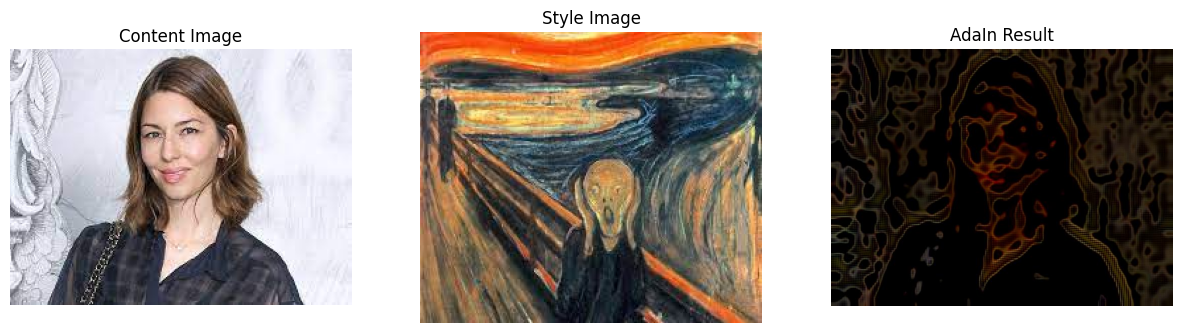

In [26]:
display_results(content_img,style_img,out_img)

# Limitations

## Noir & Blanc

L'algorithme ne fonctionnant pas sur des images en noir et blanc, nous avons effectué de légères modifications sur ce dernier afin qu'il s'adapte à ce type d'images.

Pour cela, nous regardons le nombre de canaux de l'image et si elle en possède moins de 3, nous la convertissons en image couleur (RGB).

<pre>
size = np.shape(style_image)
    if (len(size) == 2) :
        style_image = style_image.convert('RGB')
</pre>

En faisant tourner l'algorithme avec une image de style en noir et blanc et une image d'entrée en couleurs, il y a bien eu une modifications. L'image devient principalement noire et blanche mais il reste quelques touches de couleurs restantes.

En effet, la conversion en couleur peut potentiellement introduire des touches de couleurs dans l'image de style, même si elle était à l'origine en noir et blanc. De plus, si le modèle a été entraîné principalement sur des images en couleur et qu'il n'a pas été suffisamment exposé à des images en noir et blanc lors de l'entraînement, il peut avoir du mal à bien généraliser et à produire des résultats satisfaisants avec ce type d'images. Cet algorithme peut être sensible à la distribution des données sur lesquelles il est entraîné. Si la majorité des images d'entraînement sont en couleur, le modèle peut apprendre à extraire des caractéristiques spécifiques à la couleur, et ces caractéristiques pourraient ne pas être aussi pertinentes pour des images en noir et blanc.

![Texte alternatif de l'image](resources/images/exnb.png)


![Texte alternatif de l'image](data/out_img/robbie_nb.jpg)

Une image de style en noir et blanc a été appliquée sur une photo de Margot Robbie. Bien que l'ensemble de la photo soit en noir et blanc, nous pouvons constater qu'il reste quelques couleurs notamment au niveau du visage et dans l'arrière plan. De plus, les détails au niveau de la bouche ou encore de oreilles ont totalement disparu.

## Comparaison avec [(Gatys et al., 2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

**AdaIN :**

![Texte alternatif de l'image](resources/images/villecri.png)

[**(Gatys et al., 2016)**](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

![Texte alternatif de l'image](resources/images/gathys.png)

Nous pouvons voir que le transfert de style est plus efficace avec la méthode de [(Gatys et al., 2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). En effet, le transfert de texture est plus important. Cependant, leur différence de calcul est notable.

# Conclusion

D'autre approche GAN... Transport optimal (image) (approche dét) 

Parler de VGG : on peut l'entrainer sur différents datasets (par exemple comme on fait dans ArtFusion, utilisation de wikiArt qui a des styles + variés), utilisation de second order statistics (variation) et VGG (car reseau entrainé sur les images naturelles donc moins d'aspects abstraits par rapport aux peintures) 

MSCOCO : dire si il est surajusté

Parler de la rapidité : en incluant les résultats de l'article en terme de temps de calculs. 

